In [1]:
# Basic Template
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext nb_black
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from skimage.measure import compare_psnr
import cnnbin
from cnnbin.utils import psnr
from cnnbin.utils import clipto8bit

from skimage.color import rgb2gray
from skimage.measure import compare_psnr

<IPython.core.display.Javascript object>

sigma 0.1 19.995906976618464
sigma 0.1 20.01536029063141
sigma 0.1 19.96899250096112
sigma 0.2 13.968099823206126
sigma 0.2 13.971685005258113
sigma 0.2 13.969556491649023
sigma 0.3 10.447362782753583
sigma 0.3 10.44948377249822
sigma 0.3 10.481575884287418


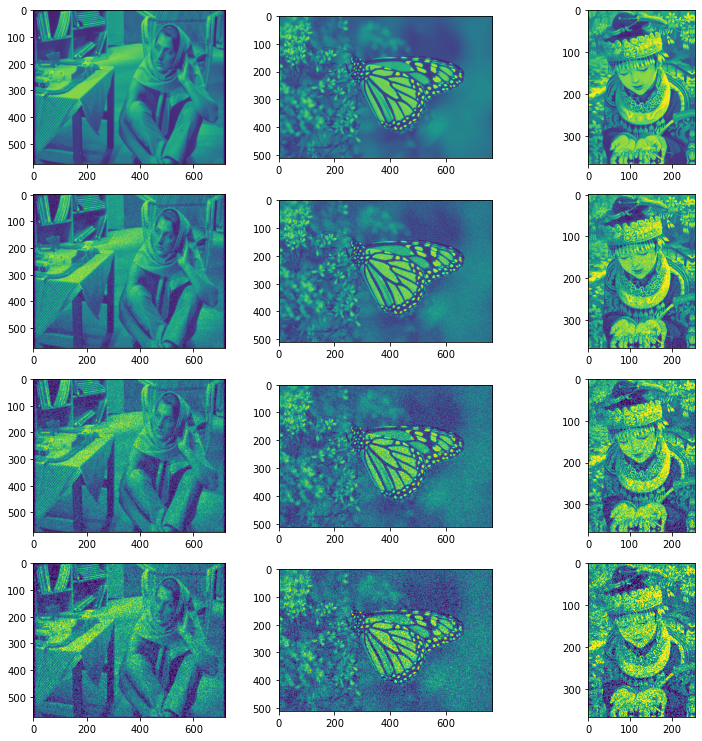

<IPython.core.display.Javascript object>

In [2]:
images_ref = [
    cnnbin.utils.pad2bin(rgb2gray(imageio.imread(x)))
    for x in ["data/barbara.bmp", "data/monarch.bmp", "data/comic.bmp"]
]

sigmas = [0.1, 0.2, 0.3]
images = []
references = []
for sigma in sigmas:
    for x in images_ref:
        images.append(x + sigma * np.random.standard_normal(x.shape))
        references.append(np.mean(cnnbin.split_diagonal(x), 0))
        print("sigma", sigma, compare_psnr(x, images[-1]))

f, ax = plt.subplots(ncols=len(images_ref), nrows=len(sigmas) + 1, figsize=(13, 13))
for ax, im in zip(ax.ravel(), images_ref + images):
    ax.imshow(im, clim=(0, 1))

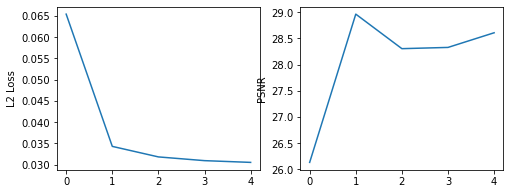

<IPython.core.display.Javascript object>

In [3]:
block_size = (128, 128)
net = cnnbin.CNNbin(multichannel=False, depth=4, start_filts=48, block_size=block_size)
net.train_list(images, num_epochs=5, samples=5, lr=1e-3, alpha=0.99)
net.plot_train()

In [4]:
filtered_images = [net.filter_patch(image).astype("double") for image in images]
scores = [compare_psnr(ref, im) for ref, im in zip(references, filtered_images)]
print(scores)

[26.646268021408336, 27.623256011108033, 22.69146776652063, 25.485342174123936, 26.25355095103768, 22.253425792362542, 24.083621619366134, 24.754661130251367, 21.489628081336214]


<IPython.core.display.Javascript object>

In [ ]:
from tqdm.notebook import tqdm
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args


class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        self._bar.update()


# https://xgboost.readthedocs.io/en/latest/parameter.html
space = [
    Integer(2, 64, name="start_filts"),
    Integer(2, 6, name="depth"),
#     Real(10 ** -6, 10 ** -1, "log-uniform", name="lr1"),
#     Real(10 ** -6, 10 ** -3, "log-uniform", name="lr2"),
#     Real(0.5, 1, name="alpha"),
]


def train_net(depth=4, start_filts=48, lr1=1e-3, lr2=1e-4, alpha=0.99):
    block_size = (128, 128)
    net = cnnbin.CNNbin(
        multichannel=False, depth=depth, start_filts=start_filts, block_size=block_size
    )
    net.train_list(images, num_epochs=10, samples=8, lr=lr1, alpha=alpha)
    net.train_list(images, num_epochs=100, samples=8, lr=lr2, alpha=alpha)
    return net


@use_named_args(space)
def objective(**params):
    #     print(params)
    net = train_net(**params)
    filtered_images = [net.filter(image).astype("double") for image in images]
    scores = [compare_psnr(ref, im) for ref, im in zip(references, filtered_images)]
    #     print(scores)

    return -np.mean(scores)


n_calls = 50
res_gp = gp_minimize(
    objective,
    space,
    n_calls=n_calls,
    random_state=0,
    callback=[tqdm_skopt(total=n_calls, desc="HyperParameter")],
)

In [ ]:
from skopt.plots import plot_convergence, plot_objective

parlist=["start_filts","depth","lr1","lr2","alpha"]
_ =plot_convergence(res_gp)
_ =plot_objective(res_gp, dimensions=parlist)


In [95]:
pardict = dict(zip(parlist, res_gp.x))

<IPython.core.display.Javascript object>

In [96]:
net = train_net(**pardict)
filtered_images = [net.filter(image).astype("double") for image in images]

<IPython.core.display.Javascript object>

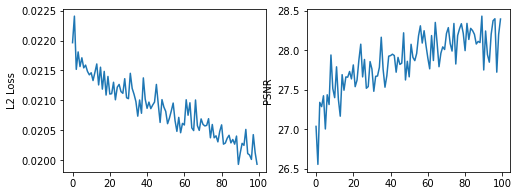

<IPython.core.display.Javascript object>

In [97]:
net.plot_train()

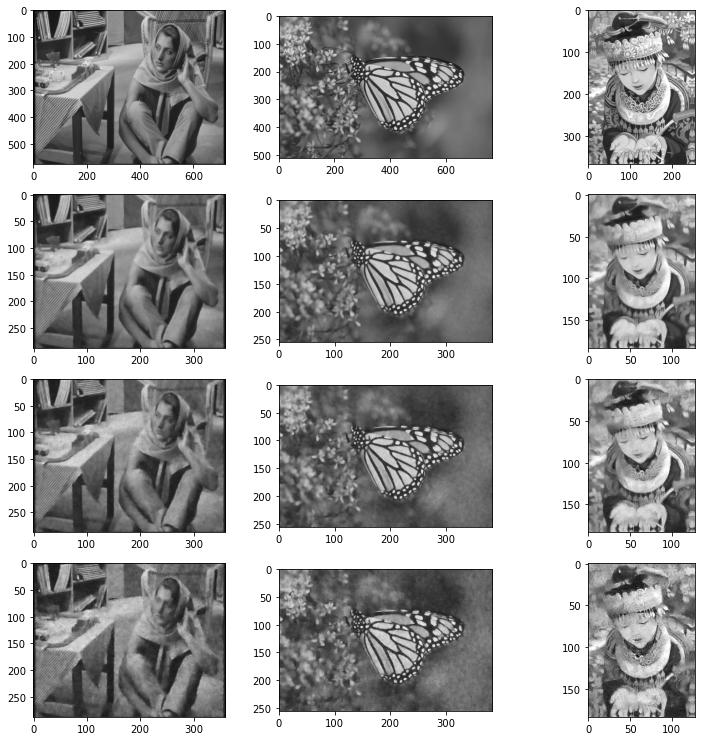

<IPython.core.display.Javascript object>

In [98]:
f, ax = plt.subplots(ncols=len(images_ref), nrows=len(sigmas) + 1, figsize=(13, 13))
for ax, im in zip(ax.ravel(), images_ref + filtered_images):
    ax.imshow(im, clim=(0, 1))